In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/owid-energy-data.csv')
print(data.head())

         country  year iso_code  population  gdp  biofuel_cons_change_pct  \
0  ASEAN (Ember)  2000      NaN         NaN  NaN                      NaN   
1  ASEAN (Ember)  2001      NaN         NaN  NaN                      NaN   
2  ASEAN (Ember)  2002      NaN         NaN  NaN                      NaN   
3  ASEAN (Ember)  2003      NaN         NaN  NaN                      NaN   
4  ASEAN (Ember)  2004      NaN         NaN  NaN                      NaN   

   biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                      NaN                      NaN                  NaN   
4                      NaN                      NaN                  NaN   

   biofuel_elec_per_capita  ...  solar_share_elec  solar_share_energy  \
0      

In [106]:
# Convert series to supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [108]:
# List of unique countries in the dataset
countries = data['country'].unique()

# Placeholder for storing models to avoid retraining for demonstration purposes
country_models = {}

# Function to preprocess data for a given country
def preprocess_data_for_country(country, data, feature='renewables_consumption'):
    # Filter data for the country
    filtered_data = data[data['country'] == country][['year', feature]].dropna()
    filtered_data.set_index('year', inplace=True)
    values = filtered_data.values

    # Normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # Convert series to supervised learning
    reframed = series_to_supervised(scaled, 1, 1)

    return reframed, scaler

# Function to train LSTM model
def train_lstm_model(data):
    # Split into inputs and outputs
    values = data.values
    X, y = values[:, :-1], values[:, -1]
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # Design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit network
    model.fit(X, y, epochs=10000, batch_size=72, verbose=0, shuffle=False)

    return model

# Loop through each country and train a model
for country in countries:
    try:
        # Preprocess the data
        reframed, scaler = preprocess_data_for_country(country, data)

        # Train the model
        model = train_lstm_model(reframed)

        # Store the model and scaler
        country_models[country] = (model, scaler)

        print(f"Model trained for {country}")
    except Exception as e:
        print(f"Could not train model for {country}: {e}")

# Predicting and plotting for a single country example (adjust 'country_example' to any country from the dataset)
country_example = 'India'
model, scaler = country_models[country_example]

# Prepare data for prediction
reframed, _ = preprocess_data_for_country(country_example, data)
values = reframed.values
X = values[:, :-1]
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Predict
yhat = model.predict(X)

# Invert scaling
X = X.reshape((X.shape[0], X.shape[2]))
inv_yhat = np.concatenate((yhat, X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

Could not train model for ASEAN (Ember): Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Could not train model for Afghanistan: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Model trained for Africa
Model trained for Africa (EI)
Could not train model for Africa (EIA): Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Could not train model for Africa (Ember): Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Could not train model for Africa (Shift): Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Could not train model for Albania: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Model trained for Algeria
Could not train model for American Samoa: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is requir

2/2 [==============================] - 0s 9ms/step


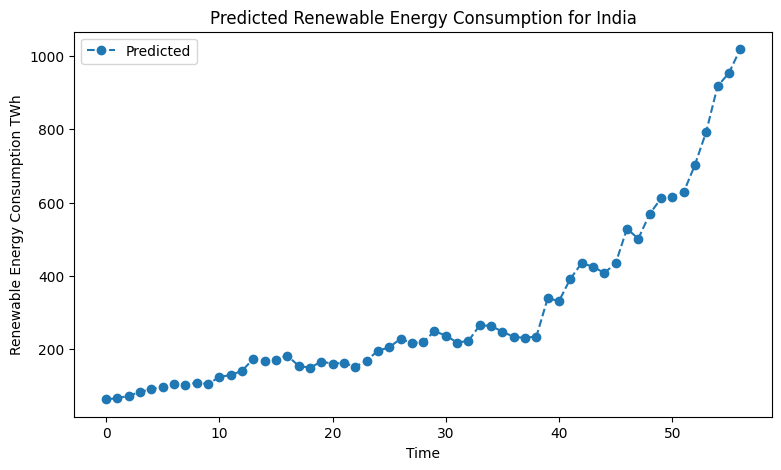

In [116]:
# Predicting and plotting for a single country example (adjust 'country_example' to any country from the dataset)
country_example = 'India'
model, scaler = country_models[country_example]

# Prepare data for prediction
reframed, _ = preprocess_data_for_country(country_example, data)
values = reframed.values
X = values[:, :-1]
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Predict
yhat = model.predict(X)

# Invert scaling
X = X.reshape((X.shape[0], X.shape[2]))
inv_yhat = np.concatenate((yhat, X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Plotting the prediction results for the example country
plt.figure(figsize=(9, 5))
plt.plot(inv_yhat, label='Predicted', marker='o', linestyle='--')
plt.title(f'Predicted Renewable Energy Consumption for India')
plt.ylabel('Renewable Energy Consumption TWh')
plt.xlabel('Time')
plt.legend()
plt.show()

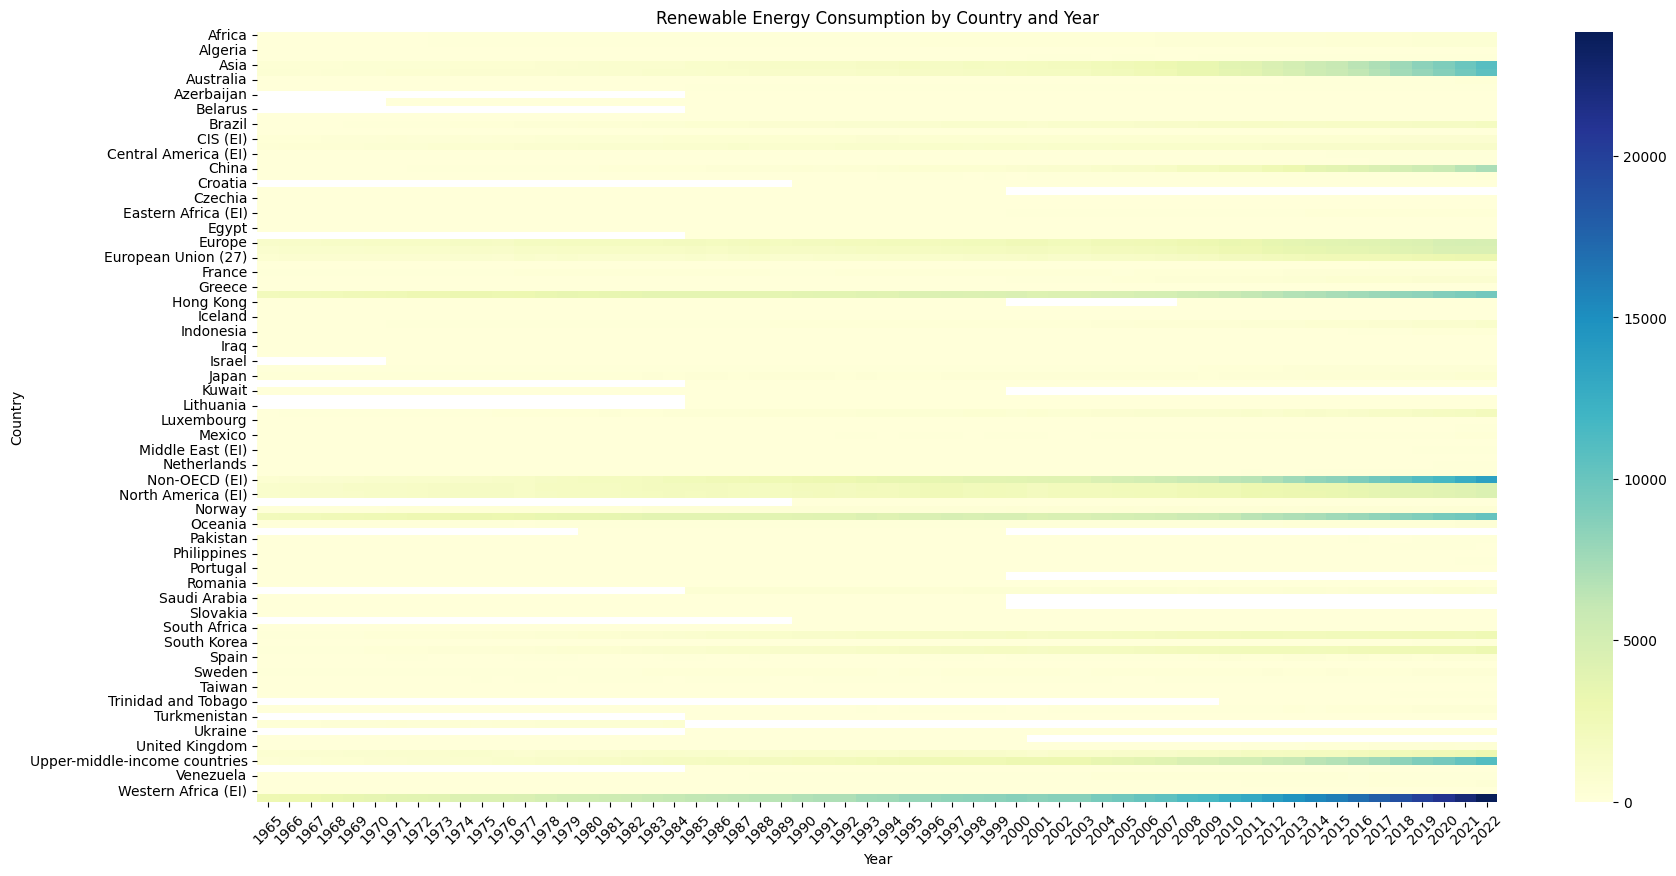

In [121]:
# Assuming 'renewables_consumption' is the correct feature name
feature = 'renewables_consumption'
data_filtered = data[['country', 'year', feature]].dropna()

# Pivot the data for heatmap
#pivot_table = data_filtered.pivot("country", "year", feature)
pivot_table = data_filtered.pivot(index='country', columns='year', values=feature)


# Plotting
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table, cmap="YlGnBu")
plt.title('Renewable Energy Consumption by Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

2/2 [==============================] - 1s 8ms/step


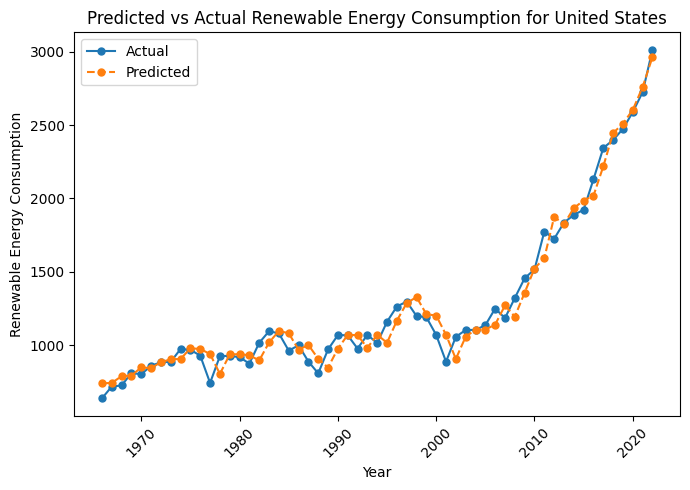

2/2 [==============================] - 1s 8ms/step


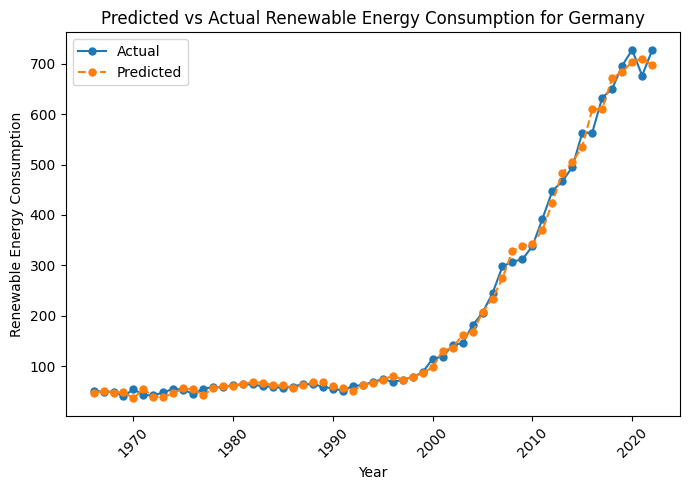

2/2 [==============================] - 0s 8ms/step


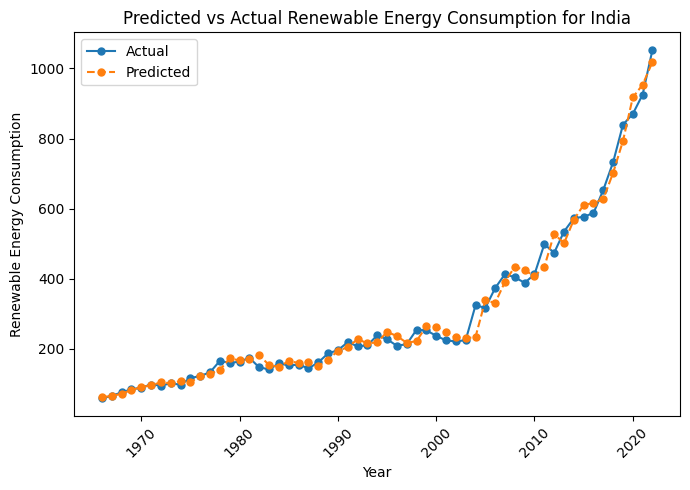

2/2 [==============================] - 1s 10ms/step


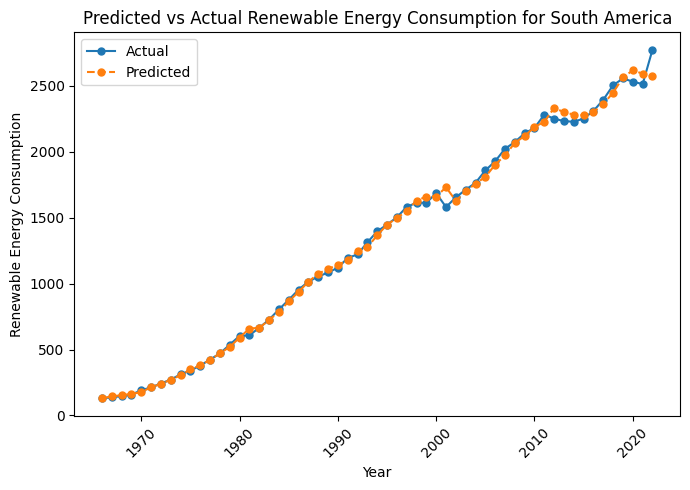

2/2 [==============================] - 0s 8ms/step


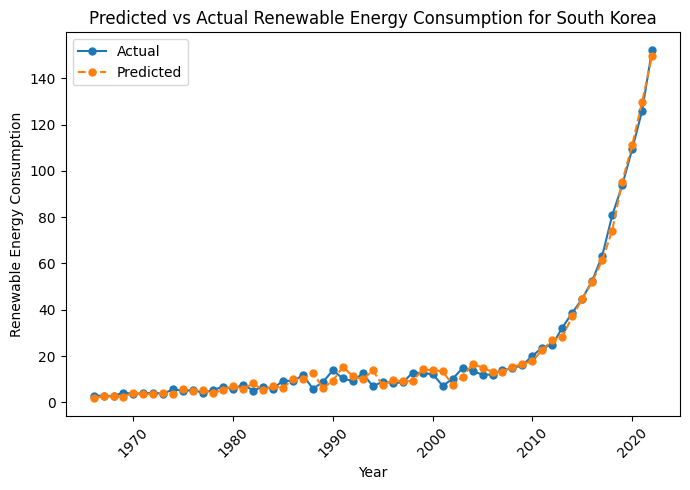

2/2 [==============================] - 1s 12ms/step


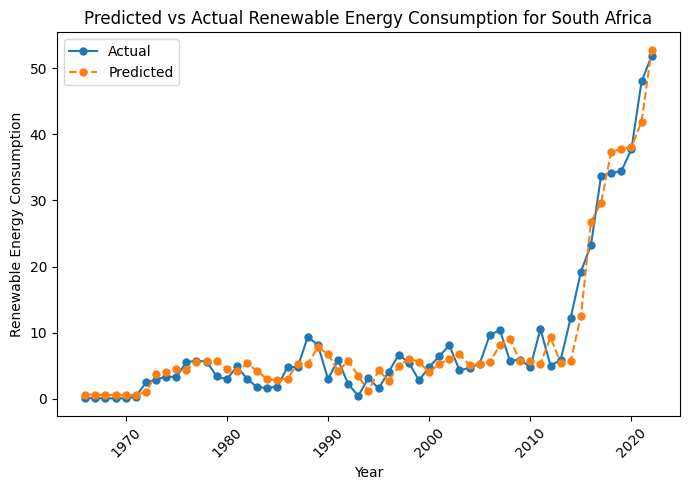

                   country  year  wind_percentage  solar_percentage
21002  Western Africa (EI)  1981         0.000000          0.000000
21003  Western Africa (EI)  1982         0.000000          0.000000
21004  Western Africa (EI)  1983         0.000000          0.000000
21005  Western Africa (EI)  1984         0.000000          0.000000
21006  Western Africa (EI)  1985         0.000000          0.000000
...                    ...   ...              ...               ...
21204                World  2018        17.686436          8.021199
21205                World  2019        18.736896          9.301355
21206                World  2020        19.807336         10.616931
21207                World  2021        21.732672         12.416383
21208                World  2022        23.010090         14.458824

[100 rows x 4 columns]


In [111]:
# Assuming 'country_models' and 'preprocess_data_for_country' functions are already defined
# List of countries to plot
countries_to_plot = ['United States', 'Germany', 'India', 'South America', 'South Korea', 'South Africa']  # Update this list as needed

# Ensure you're using the correct feature name as per your dataset
feature = 'renewables_consumption'

for country_example in countries_to_plot:
    if country_example in country_models:
        model, scaler = country_models[country_example]

        # Prepare data for prediction, ensuring we keep the year information
        filtered_data = data[data['country'] == country_example][['year', feature]].dropna()
        reframed, _ = preprocess_data_for_country(country_example, data, feature=feature)
        values = reframed.values
        X, y = values[:, :-1], values[:, -1]
        X = X.reshape((X.shape[0], 1, X.shape[1]))

        # Predict
        yhat = model.predict(X)

        # Invert scaling for forecast
        X = X.reshape((X.shape[0], X.shape[2]))
        inv_yhat = np.concatenate((yhat, X[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]

        # Invert scaling for actual renewable energy consumption
        y = y.reshape((len(y), 1))
        inv_y = np.concatenate((y, X[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]

        # Extract years from the filtered data for plotting
        years = filtered_data['year'].values[-len(inv_y):]  # Align the years with the length of inv_y and inv_yhat

        # Plotting the prediction results and actual consumption for the example country
        plt.figure(figsize=(7, 5))
        plt.plot(years, inv_y, label='Actual', marker='.', linestyle='-', markersize=10)
        plt.plot(years, inv_yhat, label='Predicted', marker='o', linestyle='--', markersize=5)
        plt.title(f'Predicted vs Actual Renewable Energy Consumption for {country_example}')
        plt.ylabel('Renewable Energy Consumption')
        plt.xlabel('Year')
        plt.xticks(rotation=45)  # Rotate the x-axis labels to make them more readable
        plt.legend()
        plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
        plt.show()
    else:
        print(f"No model available for {country_example}")

# Additional step to calculate and display wind and solar percentages
# Ensure the dataset includes 'wind_consumption' and 'solar_consumption' columns
filtered_data = data[['country', 'year', 'renewables_consumption', 'wind_consumption', 'solar_consumption']].dropna()
filtered_data['wind_percentage'] = (filtered_data['wind_consumption'] / filtered_data['renewables_consumption']) * 100
filtered_data['solar_percentage'] = (filtered_data['solar_consumption'] / filtered_data['renewables_consumption']) * 100
print(filtered_data[['country', 'year', 'wind_percentage', 'solar_percentage']].tail(100))


In [123]:
# Specify the country you're interested in
country_of_interest = 'India'

# Filter the data for the specific country
filtered_data_specific_country = filtered_data[filtered_data['country'] == country_of_interest]

# Calculate wind and solar percentages for the specific country
filtered_data_specific_country['wind_percentage'] = (filtered_data_specific_country['wind_consumption'] / filtered_data_specific_country['renewables_consumption']) * 100
filtered_data_specific_country['solar_percentage'] = (filtered_data_specific_country['solar_consumption'] / filtered_data_specific_country['renewables_consumption']) * 100

# Display the last 100 entries for the specific country
print(filtered_data_specific_country[['country', 'year', 'wind_percentage', 'solar_percentage']].tail(100))


     country  year  wind_percentage  solar_percentage
9168   India  1971         0.000000          0.000000
9169   India  1972         0.000000          0.000000
9170   India  1973         0.000000          0.000000
9171   India  1974         0.000000          0.000000
9172   India  1975         0.000000          0.000000
9173   India  1976         0.000000          0.000000
9174   India  1977         0.000000          0.000000
9175   India  1978         0.000000          0.000000
9176   India  1979         0.000000          0.000000
9177   India  1980         0.000000          0.000000
9178   India  1981         0.000000          0.000000
9179   India  1982         0.000000          0.000000
9180   India  1983         0.000000          0.000000
9181   India  1984         0.000000          0.000000
9182   India  1985         0.000000          0.000000
9183   India  1986         0.000000          0.000000
9184   India  1987         0.000000          0.000000
9185   India  1988         0

<ipython-input-123-d48d66b2dbec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_specific_country['wind_percentage'] = (filtered_data_specific_country['wind_consumption'] / filtered_data_specific_country['renewables_consumption']) * 100
<ipython-input-123-d48d66b2dbec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_specific_country['solar_percentage'] = (filtered_data_specific_country['solar_consumption'] / filtered_data_specific_country['renewables_consumption']) * 100
